#Face Mask Segmentation with UNet

Free up RAM Between Runs to Avoid Crashes

In [ ]:
import gc
gc.collect()

128

## Configurations

In [ ]:
RUN_DATA_INITIALIZATION = True
RUN_MODEL_TRAINING = True
ONE_HOT_ENCODE = True
TUNE_HYPERPARAMETERS = False

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install visualkeras
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 13.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 14.8 MB/s 


Imports

In [ ]:
import numpy as np
import cv2 as cv
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
import time
from tensorflow.keras import Input
import visualkeras
from PIL import ImageFont
import keras_tuner as kt

File Path Constants

In [ ]:
BASE_PATH = '/content/drive/My Drive/'
DATASET_PATH = 'dataset/'
PROCESSED_PATH = BASE_PATH + DATASET_PATH + 'processed_files.txt'
HDF5_PATH = BASE_PATH + DATASET_PATH + 'dataset.hdf5'
CHECKPOINT_PATH = BASE_PATH + 'checkpoints/'
MODEL_PATH = BASE_PATH + 'models/segmentation/'

Globals

In [ ]:
DATASET_SIZE = 1200
inputs = [] if 'inputs' not in globals() else inputs
segmaps = [] if 'segmaps' not in globals() else segmaps

Initialize Input and Segmap Arrays from Pickle

In [ ]:
if RUN_DATA_INITIALIZATION:
  # read images from HDF5 into numpy arrays
  h5f = h5py.File(HDF5_PATH,'r')
  inputs = h5f['masked_faces'][0:DATASET_SIZE]
  segmaps = h5f['segmentation_masks'][0:DATASET_SIZE]
  h5f.close()
  del h5f
  gc.collect()

Show Input-Label Pair Example

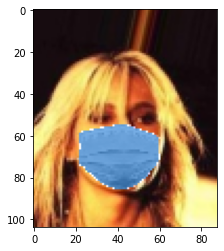

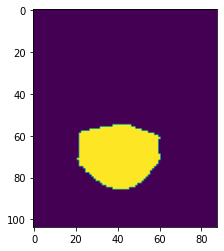

In [ ]:
rand_index = randint(0, DATASET_SIZE)
plt.imshow(inputs[rand_index])
plt.show()

plt.imshow(segmaps[rand_index])
plt.show()

Segmentation Classes Histogram

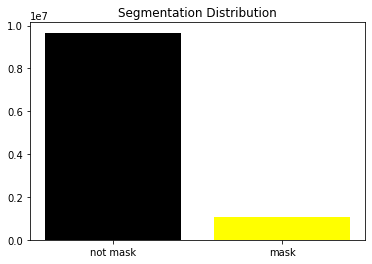

In [ ]:
values = [0] * 2
names = ['not mask', 'mask']
colors = [(0, 0, 0), (1, 1, 0)]

for ctr, segmap in enumerate(segmaps):
    for i in range(0, len(segmap) - 1):
        for j in range(0, len(segmap[i]) - 1):
            values[segmap[i][j]] += 1

plt.title('Segmentation Distribution')
plt.bar(names, values, color=colors)
plt.show()

## Create Dataset Splits

In [ ]:
x = tf.convert_to_tensor(np.array(inputs) / 255)
y = tf.one_hot(segmaps, 2, dtype='uint8') if ONE_HOT_ENCODE else segmaps

# 60:20:20 Split
train_end = (DATASET_SIZE * 3) // 5
valid_end = (DATASET_SIZE // 5) + train_end

train_data = tf.data.Dataset.from_tensors((x[:train_end], y[:train_end]))
valid_data = tf.data.Dataset.from_tensors((x[train_end:valid_end], y[train_end:valid_end]))
test_data = tf.data.Dataset.from_tensors((x[valid_end:], y[valid_end:]))

# Model Architecture

Define Double Convolution Downsampling Block

In [ ]:
def downsample(inputs, n_filters=64, kernel_dims=3, p_dropout=0.0, pool_size=2):
  # Double convolution
  conv = tf.keras.layers.Conv2D(n_filters, kernel_size=kernel_dims, padding='same', activation='relu', 
                                kernel_initializer='he_normal')(inputs)
  conv = tf.keras.layers.Conv2D(n_filters, kernel_size=kernel_dims, padding='same', activation='relu',
                                kernel_initializer='he_normal')(conv)
  
  # Add dropout with specified probability
  if p_dropout > 0.0:
    conv = tf.keras.layers.Dropout(p_dropout)(conv)
  
  skip = conv

  # Perform Max Pooling with specified pool size
  if pool_size > 0:
    pool = tf.keras.layers.MaxPool2D((pool_size, pool_size))(conv)
  else:
    pool = conv

  return pool, skip

Define Double Transpose Convolution Upsampling Block

In [ ]:
def upsample(prev_inputs, skip_inputs, n_filters=64, kernel_dims=3, stride=2):

    # Transpose convolution
    conv_t1 = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size=(kernel_dims, kernel_dims),
                                            strides=(stride, stride), padding='same')(prev_inputs)

    # Concatenate transpose convolution with skip layer
    concat = tf.keras.layers.concatenate([conv_t1, skip_inputs], axis=3)

    conv_1 = tf.keras.layers.Conv2D(n_filters, kernel_size=kernel_dims, padding='same',
                                    activation='relu', kernel_initializer='he_normal')(concat)

    conv_2 = tf.keras.layers.Conv2D(n_filters, kernel_size=kernel_dims, padding='same',
                                    activation='relu', kernel_initializer='he_normal')(conv_1)

    return conv_2

Define UNet

In [ ]:
def unet(input_shape, n_filters, n_classes):
  inputs = tf.keras.layers.Input(input_shape)

  down1 = downsample(inputs, n_filters)
  down2 = downsample(down1[0], n_filters * 2)
  down3 = downsample(down2[0], n_filters * 4)
  down4 = downsample(down3[0], n_filters * 8, pool_size=0)
  up1 = upsample(down4[0], down3[1], n_filters * 4)
  up2 = upsample(up1, down2[1], n_filters * 2)
  up3 = upsample(up2, down1[1], n_filters)

  conv = tf.keras.layers.Conv2D(n_filters, kernel_size=3, activation='relu', padding='same',
                kernel_initializer='he_normal')(up3)

  conv2 = tf.keras.layers.Conv2D(n_classes, kernel_size=1, activation='softmax', padding='same')(conv)
  
  model = tf.keras.Model(inputs=inputs, outputs=conv2)

  return model

Create UNet

In [ ]:
n_filters = 32
n_classes = 2 if ONE_HOT_ENCODE else 1
height = 104
width = 88
image_channels = 3

model = unet(input_shape=(height, width, image_channels),
             n_filters=n_filters, n_classes=n_classes)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 104, 88, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 104, 88, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 104, 88, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 52, 44, 32)   0           ['conv2d_1[0][0]']           

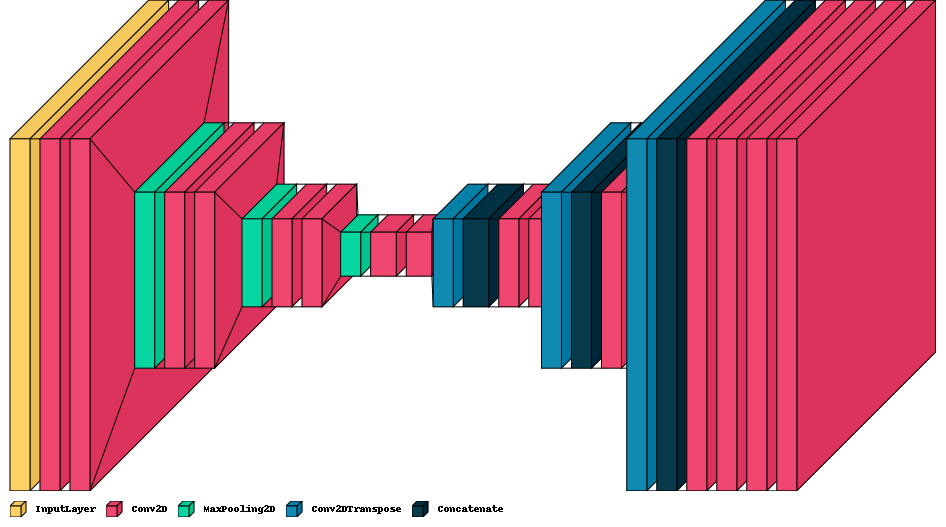

In [ ]:
visualkeras.layered_view(model, legend=True)

Tune Hyperparameters

In [ ]:
def build_model(hp):
    model = unet(input_shape=(height, width, image_channels), n_filters=n_filters, n_classes=n_classes)
    model.compile(tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')), 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))
    return model

In [ ]:
if TUNE_HYPERPARAMETERS:
    tuner = kt.Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=50,
        hyperband_iterations=2)

    tuner.search(train_data,
                 validation_data=valid_data,
                 epochs=10,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)])

In [ ]:
if TUNE_HYPERPARAMETERS:
    print(tuner.get_best_hyperparameters()[0].get('learning_rate'))

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00011183105292845106),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

Epoch 1/80
1/1 [==============================] - 21s 21s/step - loss: 0.7342 - accuracy: 0.3916 - val_loss: 0.6808 - val_accuracy: 0.5967
Epoch 2/80
1/1 [==============================] - 1s 868ms/step - loss: 0.6797 - accuracy: 0.5982 - val_loss: 0.6300 - val_accuracy: 0.7619
Epoch 3/80
1/1 [==============================] - 1s 902ms/step - loss: 0.6277 - accuracy: 0.7680 - val_loss: 0.5800 - val_accuracy: 0.8596
Epoch 4/80
1/1 [==============================] - 1s 875ms/step - loss: 0.5766 - accuracy: 0.8650 - val_loss: 0.5334 - val_accuracy: 0.8770
Epoch 5/80
1/1 [==============================] - 1s 893ms/step - loss: 0.5284 - accuracy: 0.8829 - val_loss: 0.4968 - val_accuracy: 0.8819
Epoch 6/80
1/1 [==============================] - 1s 886ms/step - loss: 0.4893 - accuracy: 0.8879 - val_loss: 0.4770 - val_accuracy: 0.8855
Epoch 7/80
1/1 [==============================] - 1s 692ms/step - loss: 0.4663 - accuracy: 0.8915 - val_loss: 0.4781 - val_accuracy: 0.8886
Epoch 8/80
1/1 [=====

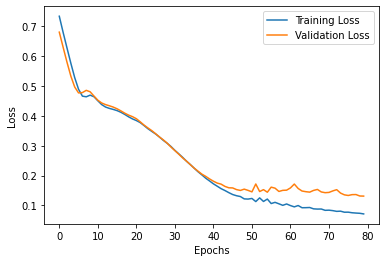

In [ ]:
if RUN_MODEL_TRAINING:
  from keras.callbacks import ModelCheckpoint, EarlyStopping
  tf.keras.backend.clear_session()
  checkpoint = ModelCheckpoint(CHECKPOINT_PATH + 'segmentation_norm_80.h5', monitor='val_loss', save_best_only=True)
  history = model.fit(train_data, batch_size=16, epochs=80, verbose=1, shuffle=True, validation_data=valid_data, callbacks=[checkpoint])

  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()
else:
    #history = model.load_weights(BASE_PATH + 'final_weights/segmentation_weights_98_accuracy.h5')
    model = tf.keras.models.load_model(MODEL_PATH)

In [ ]:
outputs = model.predict(test_data, batch_size=16)

In [ ]:
print(outputs[0])

[[[4.9835587e-01 5.0164407e-01]
  [6.8609524e-01 3.1390473e-01]
  [6.7050278e-01 3.2949719e-01]
  ...
  [6.5661353e-01 3.4338653e-01]
  [6.2577277e-01 3.7422726e-01]
  [5.5656785e-01 4.4343215e-01]]

 [[5.5605686e-01 4.4394311e-01]
  [6.5519589e-01 3.4480411e-01]
  [7.4971986e-01 2.5028017e-01]
  ...
  [7.9844087e-01 2.0155910e-01]
  [6.7880243e-01 3.2119751e-01]
  [6.9010454e-01 3.0989546e-01]]

 [[6.3959408e-01 3.6040595e-01]
  [8.9871877e-01 1.0128122e-01]
  [8.8641453e-01 1.1358548e-01]
  ...
  [8.9022917e-01 1.0977087e-01]
  [8.6645472e-01 1.3354529e-01]
  [8.3380675e-01 1.6619329e-01]]

 ...

 [[9.9712604e-01 2.8739143e-03]
  [9.9983430e-01 1.6566936e-04]
  [9.9999607e-01 3.8854523e-06]
  ...
  [9.9998891e-01 1.1077415e-05]
  [9.9965119e-01 3.4880440e-04]
  [9.9971682e-01 2.8316810e-04]]

 [[9.7479522e-01 2.5204761e-02]
  [9.9958354e-01 4.1647919e-04]
  [9.9961913e-01 3.8090593e-04]
  ...
  [9.9999845e-01 1.6013687e-06]
  [9.9971277e-01 2.8720766e-04]
  [9.9819821e-01 1.8018573e-

In [ ]:
# Convert from logits to binary segmentation map
#outputs = outputs[0]
outputs = np.array(outputs).argmax(3)

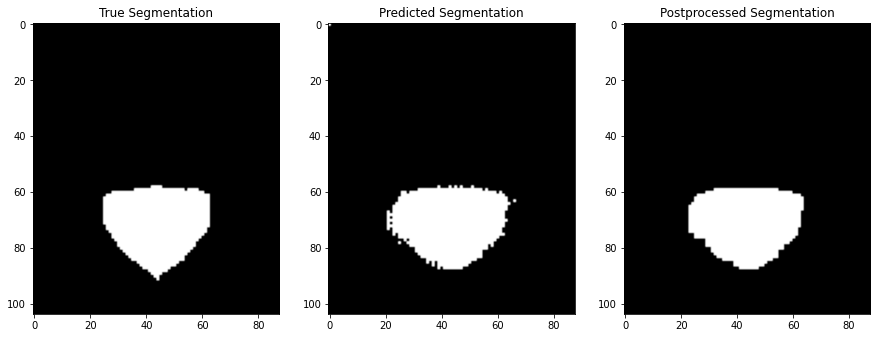

In [ ]:
index = 0

post_processed = outputs[index].astype(np.uint8)

# # remove noise in segmentation map
kernel2 = np.ones((5, 5), np.uint8)
post_processed = cv.morphologyEx(post_processed, cv.MORPH_OPEN, kernel2)
# post_processed = cv.dilate(post_processed, kernel2)

# close holes in mask
# kernel1 = np.ones((3, 3), np.uint8)
# post_processed = cv.dilate(post_processed, kernel1, iterations=1)
# kernel2 = np.ones((3, 3), np.uint8)
# post_processed = cv.erode(post_processed, kernel2, iterations=1)

figure = plt.figure(figsize=(15, 15))

# original = figure.add_subplot(131)
# plt.imshow(inputs[valid_end + index])

expected = figure.add_subplot(131)
plt.imshow(segmaps[valid_end + index], 'Greys_r')

predicted = figure.add_subplot(132)
plt.imshow(outputs[index],'Greys_r')

post = figure.add_subplot(133)
plt.imshow(post_processed,'Greys_r')

# original.title.set_text('Original Image')
expected.title.set_text('True Segmentation')
predicted.title.set_text('Predicted Segmentation')
post.title.set_text('Postprocessed Segmentation')

In [ ]:
#model.save(MODEL_PATH)

In [ ]:
whole_data = tf.data.Dataset.from_tensors((x, y))
whole_outputs = model.predict(whole_data, batch_size=16)
whole_outputs = np.array(whole_outputs).argmax(3)

post_processed_outputs = outputs.astype(np.uint8)
kernel2 = np.ones((5, 5), np.uint8)
for i in range(0, len(post_processed_outputs)):
    post_processed_outputs[i] = cv.morphologyEx(post_processed_outputs[i], cv.MORPH_OPEN, kernel2);

f = h5py.File(BASE_PATH + 'predicted_segmaps.hdf5', 'w')
f.create_dataset('segmaps', data=post_processed_outputs)
f.close()